这篇文档是用来做segmentation的，因为faster r-cnn真的是train不动了。
<br>
那玩意我调了好几天，少说得有二十多个小时了，太乱了。
<br>
所以现在的策略是使用和楼类似的方法分割图片。所以这篇文档做的事情和楼做的重复性很高
<br>
不过lou的代码我有点看不懂，所以就自己写一遍吧 X﹏X

In [1]:
import cv2
import torch
import random
import numpy as np
from utils import *
from CRNN import *
from matplotlib import pyplot as plt
import time

dataset = SegDataset('IAM', 'val')

In [2]:
# load model
model = CRNN()
model_name = get_model_name(15, "CRNN")
model_path = "/root/autodl-tmp/APS360_Project/Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

# utils
def show_img(img: torch.Tensor):
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

基本策略（草稿）：
先总结图片的像素分布，然后把图片二值化
然后把图片变模糊

index: 30
" No , " she tod Phil fullion , a juinen 
 homeamen , " it wan , I thiger you sam , 
 my lad " . If was Wiged , a can , comagages . 
 Ur I 13s " . He probably loved his can 
 to sundely , Thil . He 's always doing that " 
 Young fiflition shanged . " ? chile it see his 
 face , Dr . , but it centainaly losted like 
 Whied from the back . D I . . and all . 
 of course such as I coulder it afford 
 to go , into the docal of Scoulder . " 
 


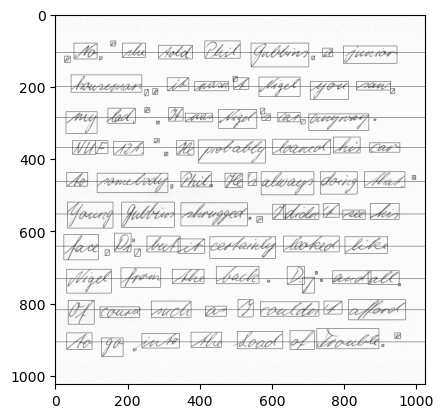

True

In [62]:
# 将图片二值化
_conv = torch.nn.Conv2d(1, 1, 3, padding=1, bias=False)
_conv.weight.data = torch.tensor([[[[0.3, 1, 0.3], [1, 3, 1], [0.3, 1, 0.3]]]], dtype=torch.float32)
def non_maximum_suppression(img, lower_bound=150, upper_bound=200):
    lower_bound = 1 - lower_bound / 255
    upper_bound = 1 - upper_bound / 255
    # 将图片变成0-1之间，并且黑白颠倒
    img = 1 - img / 255
    # 创建一个副本，用于存储结果
    new_img = torch.zeros_like(img)
    # 如果图片像素超过upper/lower bound，就直接设置为1/0
    indices = torch.where(img > lower_bound)
    new_img[indices] = 1
    indices = torch.where(img < upper_bound)
    new_img[indices] = 0
    # 对剩下的像素进行卷积，如果周围有很多像素是1，那么就设置为1
    for _ in range(10):
        temp = _conv(new_img.unsqueeze(0)).squeeze(0)
        indices = torch.where(temp >= 1.5)
        new_img[indices] = 1
    return new_img

# 找到连通的像素
def find_connected_pixels(img: torch.Tensor, finded_img: torch.Tensor, same_group: list, x, y):
    """
    args:
        img: 原始图片
        finded_img: 已经找到的像素图片，找到了标记为1，否则为0
        same_group: 相同的区域的像素，[(x1, y1), (x2, y2), ...]
        x: x坐标
        y: y坐标
    """
    # 如果坐标越界，直接返回
    if x < 0 or y < 0 or x >= img.shape[1] or y >= img.shape[2]:
        return
    # 如果已经找到了，直接返回
    if finded_img[x, y] == 1:
        return
    # 如果不是白色（笔画），直接返回
    if img[0, x, y] != 1:
        return
    # 标记为已找到
    finded_img[x, y] = 1
    # 添加到相同区域
    same_group.append((x, y))
    # 递归查找周围的像素
    find_connected_pixels(img, finded_img, same_group, x-1, y)
    find_connected_pixels(img, finded_img, same_group, x+1, y)
    find_connected_pixels(img, finded_img, same_group, x, y-1)
    find_connected_pixels(img, finded_img, same_group, x, y+1)

def find_all_connected_pixels(img: torch.Tensor):
    """
    args:
        img: 原始图片
    return:
        所有的相同区域的像素，[[(x1, y1), (x2, y2), ...], [(x1, y1), (x2, y2), ...], ...]
    """
    import sys
    sys.setrecursionlimit(1000000)
    # 创建一个副本，用于存储结果
    finded_img = torch.zeros(img.shape[1:], dtype=torch.uint8)
    # 所有的相同区域的像素
    all_same_group = []
    # 遍历所有像素
    for x in range(img.shape[1]):
        for y in range(img.shape[2]):
            # 如果已经找到了，直接返回
            if finded_img[x, y] == 1:
                continue
            # 如果不是白色（笔画），直接返回
            if img[0, x, y] != 1:
                continue
            # 新的相同区域
            same_group = []
            # 查找相同区域的像素
            find_connected_pixels(img, finded_img, same_group, x, y)
            # 添加到所有相同区域
            all_same_group.append(same_group)
    # # 如果有的点太小，则删除
    # all_same_group = [x for x in all_same_group if len(x) > 25]
    return all_same_group

# 对于每个相同区域，找到最小的矩形
def find_min_rectangle(all_same_group, bias=1):
    """
    args:
        all_same_group: 所有的相同区域的像素，[[(x1, y1), (x2, y2), ...], [(x1, y1), (x2, y2), ...], ...]
        bias: 为了更加精确，将矩形缩小一点
    return:
        所有的矩形，[(x1, y1, x2, y2), (x1, y1, x2, y2), ...]
    """
    rectangles = []
    for same_group in all_same_group:
        x1 = min([x for y, x in same_group]) + bias  # 这里之所以使用 y, x 是因为之前有一个小bug，所以这里是反的
        y1 = min([y for y, x in same_group]) + bias
        x2 = max([x for y, x in same_group]) - bias
        y2 = max([y for y, x in same_group]) - bias
        if x1 >= x2 or y1 >= y2:
            continue
        rectangles.append((x1, y1, x2, y2))
    
    # 如果有一个矩形太大，就删除
    for i in range(len(rectangles)):
        x1, y1, x2, y2 = rectangles[i]
        if x2 - x1 > 500 or y2 - y1 > 100:
            rectangles[i] = None
    rectangles = [x for x in rectangles if x is not None]
    
    # 如果有一个矩形太小，就删除
    for i in range(len(rectangles)):
        x1, y1, x2, y2 = rectangles[i]
        if x2 - x1 < 3 and y2 - y1 < 3:
            rectangles[i] = None
    rectangles = [x for x in rectangles if x is not None]

    # 如果有一个矩形包含另一个矩形，就删除
    for i in range(len(rectangles)):
        for j in range(i+1, len(rectangles)):
            if rectangles[i] is None or rectangles[j] is None:
                continue
            x1, y1, x2, y2 = rectangles[i]
            x3, y3, x4, y4 = rectangles[j]
            if x1 <= x3 and y1 <= y3 and x2 >= x4 and y2 >= y4:
                rectangles[j] = None
            if x1 >= x3 and y1 >= y3 and x2 <= x4 and y2 <= y4:
                rectangles[i] = None
    rectangles = [x for x in rectangles if x is not None]

    return rectangles

# 定义一个行class，用于存储行的信息
class Row:
    def __init__(self, rect, avg_height):
        self.avg_height = avg_height
        self.threshold = avg_height * 0.75
        self.y_mean = (rect[1] + rect[3]) / 2
        self.rectangles = []
    
    def in_range(self, rect):
        y1, x1, y2, x2 = rect
        y_mean = (y1 + y2) / 2
        if abs(y_mean - self.y_mean) < self.threshold:
            return True
        return False

    def add_rectangle(self, rect):
        self.rectangles.append(rect)
        # 更新y_mean
        self.y_mean = sum([(rect[0] + rect[2]) / 2 for rect in self.rectangles]) / len(self.rectangles)
    
    def sort_rects_x(self):
        self.rectangles = sorted(self.rectangles, key=lambda x: (x[1] + x[3]) / 2)


# 将所有格子排序
def sort_rectangles(rectangles):
    rows = []
    avg_height = sum([y2-y1 for y1, x1, y2, x2 in rectangles]) / len(rectangles)
    for rect in rectangles:
        y1, x1, y2, x2 = rect

        for row in rows:
            if row.in_range(rect):
                row.add_rectangle(rect)
                break
        else:
            rows.append(Row(rect, avg_height))
            rows[-1].add_rectangle(rect)
    
    # 如果一行之中，有一个rect刚好在另一个rect的上面/下面，那么就合并
    for row in rows:
        for i in range(len(row.rectangles)):
            for j in range(i+1, len(row.rectangles)):
                if row.rectangles[i] is None or row.rectangles[j] is None:
                    continue
                y1, x1, y2, x2 = row.rectangles[i]
                y3, x3, y4, x4 = row.rectangles[j]
                if x1 <= x3 and x2 >= x4:  # 此时第二个rect比较小
                    row.rectangles[i] = (min(y1, y3), x1, max(y2, y4), x2)
                    row.rectangles[j] = None
                if x1 >= x3 and x2 <= x4:  # 此时第一个rect比较小
                    row.rectangles[j] = (min(y1, y3), x3, max(y2, y4), x4)
                    row.rectangles[i] = None
        row.rectangles = [x for x in row.rectangles if x is not None]

    rows = sorted(rows, key=lambda x: x.y_mean)

    rectangles = []
    for row in rows:
        row.sort_rects_x()
        rectangles.extend(row.rectangles)
    return rectangles, rows


def get_word_image(img: torch.Tensor, rect):
    y1, x1, y2, x2 = rect
    img = img[:, y1:y2, x1:x2].detach().cpu().numpy()
    # pad image
    w, h = img.shape[2], img.shape[1]
    new_len = w if w > h else h
    new_img = np.ones((1, new_len, new_len), dtype=np.float32) * 255
    new_img[:, (new_len-h)//2:(new_len-h)//2+h, (new_len-w)//2:(new_len-w)//2+w] = img
    # resize image
    new_img = cv2.resize(new_img[0], (128, 128)).reshape(1, 128, 128)
    # convert to (-1, 1) range
    new_img -= new_img.min()
    new_img /= (new_img.max() + 1e-6) / 2
    new_img -= 1
    # convert to tensor
    new_img = torch.tensor(new_img, dtype=torch.float32)
    return new_img


def predict(model, original_img: torch.Tensor):
    ans = dict()
    img = original_img.clone()
    ans["original"] = img
    # 将像素从暗到亮排序
    temp = img.detach().cpu().numpy().reshape(-1)
    temp = np.sort(temp)
    # 找到阈值
    lower_bound = temp[int(len(temp) * 0.03)]
    upper_bound = temp[int(len(temp) * 0.1)]
    # 非极大值抑制
    img = non_maximum_suppression(img, lower_bound, upper_bound)
    img = img[:, ::2, ::2]
    all_same_group = find_all_connected_pixels(img)
    img = original_img.clone()
    rectangles = find_min_rectangle(all_same_group)
    rectangles = [[y1*2, x1*2, y2*2, x2*2] for x1, y1, x2, y2 in rectangles]
    rectangles, rows = sort_rectangles(rectangles)
    ans["rectangles"] = rectangles
    ans["rows"] = rows
    
    # 接下来是识别单词
    words = []
    for row in rows:
        batch = []
        for rect in row.rectangles:
            y1, x1, y2, x2 = rect
            word_img = get_word_image(img, rect)
            batch.append(word_img)
        batch = torch.stack(batch).to("cuda:0")
        output, probabilities = model.forward_beam(batch)
        output = model.to_words(output)
        words.extend(output)
        words.append('\n')
    ans["word_list"] = words
    
    # 整理成一个字符串
    paragraph = ""
    for word in words:
        paragraph += word + " "
    ans["paragraph"] = paragraph
    return ans

index = random.randint(0, len(dataset)-1)
print("index:", index)
img = dataset[index][0].clone()

ans = predict(model, img)
print(ans["paragraph"])

# 画出所有矩形
img = dataset[index][0].clone()
# for rect in ans["rectangles"]:
#     x1, y1, x2, y2 = rect
#     img[0, x1:x2, y1] = 0
#     img[0, x1:x2, y2] = 0
#     img[0, x1, y1:y2] = 0
#     img[0, x2, y1:y2] = 0

# 给每一行画一条线
for row in ans["rows"]:
    y = int(row.y_mean)
    img[0, y, :] = 0
    for rect in row.rectangles:
        y1, x1, y2, x2 = rect
        img[0, y1, x1:x2] = 0
        img[0, y2, x1:x2] = 0
        img[0, y1:y2, x1] = 0
        img[0, y1:y2, x2] = 0


show_img(img)
# 把image保存下来
cv2.imwrite('test.png', img[0].numpy())

Hellow ? 
 his let me tell you my secret : 
 I have a wist in my need 
 


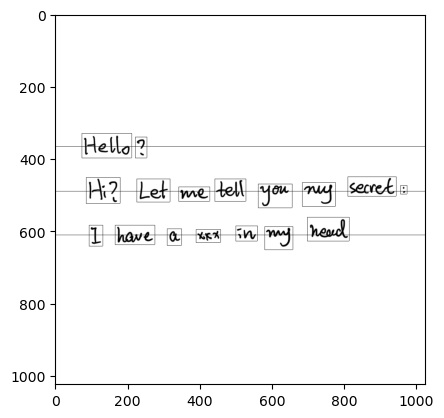

True

In [65]:
# 让模型能够应付一张保存在本地的图片
img = cv2.imread('69545701151adf46bd42884037b1856.jpg', cv2.IMREAD_GRAYSCALE)
# pad image
w, h = img.shape[1], img.shape[0]
new_len = w if w > h else h
new_img = np.ones((new_len, new_len), dtype=np.uint8) * 255
new_img[(new_len-h)//2:(new_len-h)//2+h, (new_len-w)//2:(new_len-w)//2+w] = img
# resize image
new_img = cv2.resize(new_img, (1024, 1024))
new_img = new_img.reshape(1, 1024, 1024)
new_img = torch.tensor(new_img, dtype=torch.float32)

ans = predict(model, new_img)
print(ans["paragraph"])

img = new_img.clone()
# for rect in ans["rectangles"]:
#     x1, y1, x2, y2 = rect
#     img[0, x1:x2, y1] = 0
#     img[0, x1:x2, y2] = 0
#     img[0, x1, y1:y2] = 0
#     img[0, x2, y1:y2] = 0

# 给每一行画一条线
for row in ans["rows"]:
    y = int(row.y_mean)
    img[0, y, :] = 0
    for rect in row.rectangles:
        y1, x1, y2, x2 = rect
        img[0, y1, x1:x2] = 0
        img[0, y2, x1:x2] = 0
        img[0, y1:y2, x1] = 0
        img[0, y1:y2, x2] = 0


show_img(img)
# 把image保存下来
cv2.imwrite('test.png', img[0].numpy())
